<div style="
    font-family: Arial, sans-serif; 
    margin: 50px auto; 
    padding: 40px; 
    max-width: 6000px; 
    background: #e6f7ff; 
    border-radius: 20px; 
    border: 4px solid; 
    border-image-slice: 1; 
    border-width: 6px; 
    border-image-source: linear-gradient(to right, #6a11cb, #2575fc); 
    box-shadow: 0 8px 15px rgba(0, 0, 0, 0.2);
    text-align: center;
    color: #333;
">
    <h1 style="
        margin: 0 0 15px; 
        font-size: 32px; 
        font-weight: bold; 
        color: #6a11cb;">
        <strong>Machine Learning & Modeling</strong>
    </h1>
    <p style="
        font-size: 16px; 
        text-align: justify;
        line-height: 1.5; 
        color: #555;">
        <strong>Tasks I have Done:</strong><br>
    1. task <br>
    2. task <br>
    3. task <br>
    4. task <br>
    </p>
</div>


In [114]:
import pandas as pd # data processing
import numpy as np # linear algebra
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
import math # math functions
from IPython.display import HTML, display # display HTML
from scipy import stats # statistics

# Machine Learning
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import xgboost as xgb

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

#### Making a Dataframe from cleaned data

In [115]:
df_c = pd.read_csv('cleaned_data.csv')
df_c.head()

,Year,Location,Area,Rainfall,Temperature,Soil type,Irrigation,Yeilds,Humidity,Crops,Price,Season
0,2004,Mangalore,1279,2903.1,27.0,Alluvial,Drip,2570.0,57.0,Coconut,200000,Kharif
1,2004,Mangalore,13283,2903.1,27.0,Alluvial,Drip,27170.0,57.5,Coconut,4847,Kharif
2,2004,Mangalore,52119,2903.1,27.0,Alluvial,Drip,114744.0,57.0,Coconut,51239,Kharif
3,2004,Mangalore,725,2996.6,27.0,Alluvial,Drip,1402.0,55.0,Coconut,216396,Kharif
4,2004,Mangalore,12885,2996.6,27.0,Alluvial,Drip,23456.0,56.0,Coconut,2644,Kharif


#### - correlation of numerical values


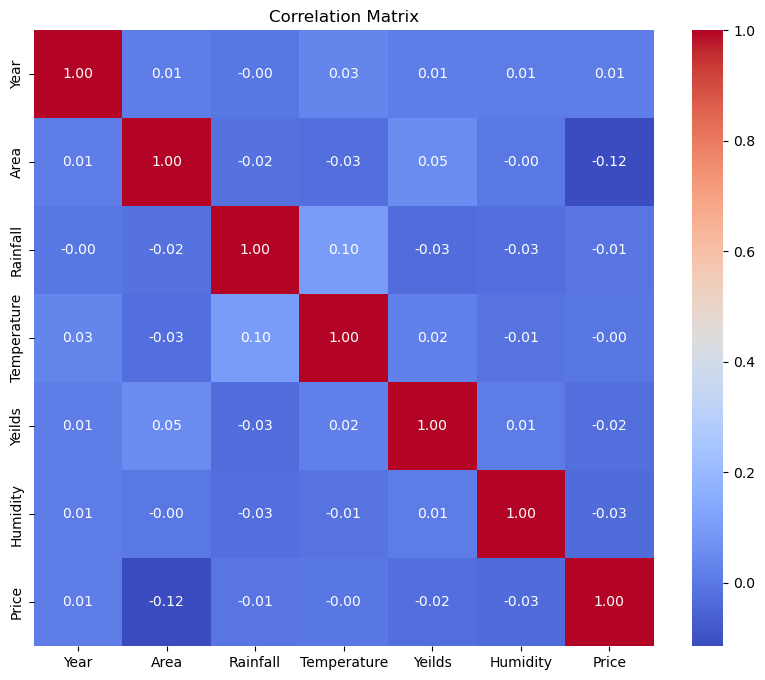

In [116]:
# Plot a correlation matrix
plt.figure(figsize=(10, 8))
numeric_df = df_c.select_dtypes(include=[np.number])  # Select only numeric columns
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### - Feature Selection

In [117]:
# Define features (X) and target (y)
X = df_c.drop(columns=['Yeilds'])  # Drop the target variable
y = df_c['Yeilds']  # Target variable

In [ ]:
# Encode categorical variables
le = LabelEncoder()
for column in X.select_dtypes(include=['object']):
    X[column] = le.fit_transform(X[column])

In [119]:
# Handle outliers in 'Price' by applying log transformation
df_c["Price"] = np.log1p(df_c["Price"])  # log1p to avoid log(0) issues

### Create and fit the random forest model

In [120]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

RandomForestRegressor(random_state=42)

#### - Get feature importances

In [121]:
importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)

#### - Display the top 10 important features


In [122]:
print(feature_importance.head(10))


       feature  importance
0         Area    0.232251
1         Year    0.102552
2        Price    0.100998
3     Rainfall    0.098963
4  Temperature    0.090526
5     Humidity    0.088903
6    Soil type    0.085667
7     Location    0.057115
8        Crops    0.055435
9   Irrigation    0.047032


<p style="font-size: 16px; text-align: justify; line-height: 1.5; color: red;">
    The most important feature (Area) only accounts for about 20% of the importance.There's a gradual decrease in importance across features, without any clear cut-off.Even the least important feature (Irrigation) still contributes about 4.5% to the model's decisions.
</p>

### Feature Engineering


In [123]:
X['RainfallTemp'] = X['Rainfall'] * X['Temperature']
X['GrowingDegreeDays'] = np.maximum(X['Temperature'] - 10, 0) 

#### - Standardize numerical features


In [124]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### - Apply PCA


In [125]:
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

#### - Use Gradient Boosting for feature importance


In [126]:
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_pca, y)

GradientBoostingRegressor(random_state=42)

#### - Get feature importances

In [127]:
importances = gb_model.feature_importances_
feature_importance = pd.DataFrame({'feature': range(len(importances)), 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)

print("Top 10 PCA components by importance:")
print(feature_importance.head(10))

Top 10 PCA components by importance:
   feature  importance
0        2    0.150073
1        8    0.147910
2       10    0.127477
3        3    0.127298
4        0    0.079865
5        6    0.077790
6        5    0.077567
7        4    0.061648
8        9    0.060649
9        7    0.049200


<p style="font-size: 16px; text-align: justify; line-height: 1.5; color: red;">
The analysis reveals that crop yields are influenced by multiple factors, with no single dominant predictor.<br><br> Area, temperature, and price emerge as the most influential individual features, but their relatively low importance scores (20% or less) suggest a complex, possibly non-linear relationship between these factors and crop yields.<br><br> The gradual decrease in importance across features indicates that many variables contribute to yield prediction, rather than just a few key factors.<br><br> This complexity is further supported by the PCA results, which show that combinations of features (represented by PCA components) are also important.<br><br> Overall, these findings suggest that predicting crop yields requires considering a wide range of interacting factors, and simple linear models may not capture the full complexity of the relationships in the data.
</p>

## Model Selection

In [128]:
df_c.head(3) # Show the first 3 rows of the dataframe

,Year,Location,Area,Rainfall,Temperature,Soil type,Irrigation,Yeilds,Humidity,Crops,Price,Season
0,2004,Mangalore,1279,2903.1,27.0,Alluvial,Drip,2570.0,57.0,Coconut,12.206078,Kharif
1,2004,Mangalore,13283,2903.1,27.0,Alluvial,Drip,27170.0,57.5,Coconut,8.486322,Kharif
2,2004,Mangalore,52119,2903.1,27.0,Alluvial,Drip,114744.0,57.0,Coconut,10.844276,Kharif


<p style="font-size: 16px; text-align: justify; line-height: 1.5; color: red;">
    XGBoost can handles non-linear relationships effectively.
</p>

In [129]:
# # One-hot encode categorical variables
# df_c = pd.get_dummies(df_c, columns=['Location', 'Soil type', 'Irrigation', 'Crops', 'Season'], drop_first=True)

from sklearn.preprocessing import OneHotEncoder

# Apply One-Hot Encoding
X = pd.get_dummies(X, columns=X.select_dtypes(include=['object']).columns, drop_first=True)

#### - Preparing data

In [130]:
# Define features (X) and target (y)
X = df_c.drop('Yeilds', axis=1)
# X = df_c.drop(columns=["Yeilds", "Price"]) 
y = df_c['Yeilds']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### - Initialize and fit the model

In [131]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Location: object, Soil type: object, Irrigation: object, Crops: object, Season: object

#### - Make predictions

In [ ]:
y_pred = model.predict(X_test)

#### - Evaluate the model

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')


Mean Squared Error: 5796833642.971235
Root Mean Squared Error: 76136.94006834814


<p style="font-size: 16px; text-align: justify; line-height: 1.5; color: red;">
    A high MSE indicates that, on average, the squared differences between predicted and actual values are large. This suggests that the model is not accurately capturing the underlying patterns in the data.
</p>

In [ ]:
# Assuming y_test and y_pred are already defined
r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

R² Score: 0.021679677754761206


<!-- This is developed by Dinitha Wickramasinghe 10898942 -->

# Improving the Model


## - Hyperparameter Tuning

##### XGBoost has several parameters that impact model performance. We will tune:
•	n_estimators: Number of boosting rounds (trees).<br>
•	max_depth: Maximum tree depth (controls model complexity).<br>
•	learning_rate: Shrinks the contribution of each tree to prevent overfitting.<br>
•	subsample: Fraction of training data used per tree (helps generalization).<br>
•	colsample_bytree: Fraction of features used per tree (reduces overfitting).<br>

In [ ]:
# Define a smaller parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

# Initialize the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Grid search with reduced number of parallel jobs
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END c

In [ ]:
# Train the model with best parameters
best_xgb = xgb.XGBRegressor(**grid_search.best_params_, objective='reg:squarederror', random_state=42)
best_xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred = best_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Improved Mean Squared Error: {mse}')
print(f'Improved Root Mean Squared Error: {rmse}')

Improved Mean Squared Error: 5577552138.091128
Improved Root Mean Squared Error: 74683.011040605


<!-- This is developed by Dinitha Wickramasinghe 10898942 -->

<h1 style="font-size: 48px; text-align: center; color: red;">
    Model Demonstration
</h1>

## Save the Trained Model as a Pickle Object

In [ ]:
import pickle

# Save the model
with open('crop_yield_model.pkl', 'wb') as file: #wb is write binary, crop_yield_model.pkl is the model name
    pickle.dump(best_xgb, file) #best_xgb is the model name